# **Proyek Analisis Sentimen : Review Aplikasi Perbankan Livin By Mandiri di Playstore**
* **Nama : Nelson Lau**
* **Email : mc006d5y2185@student.devacademy.id**
* **ID Dicoding : MC006D5Y2185**

# **Import Library**

In [6]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!pip install sastrawi

In [8]:
import pandas as pd
import re
import requests
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from io import StringIO
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer


# **Memuat Dataset**

In [9]:
#Menampilkan dataset livin_reviews
nel = pd.read_csv("livinbymandiri_reviews.csv")
nel.head()

,review,rating,tanggal
0,"Good job, Mudah dan nyaman",5,2025-03-23 05:51:05
1,payah,1,2025-02-07 22:42:52
2,Sangat bermanfaat dan aplikasi jg mudah diguna...,5,2025-01-28 00:16:31
3,Saya sangat senang,5,2024-10-18 20:45:13
4,Sangat praktis.,5,2024-10-11 23:31:13


In [10]:
#Menampilkan jumlah baris dan kolom
nel.shape

(50000, 3)

In [11]:
#Menampilkan tipe data
nel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   50000 non-null  object
 1   rating   50000 non-null  int64 
 2   tanggal  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [12]:
#Memeriksa apakah data mengalami missing values
nel.isnull().sum()

,0
review,0
rating,0
tanggal,0


In [13]:
#Menampilkan distribusi rating
nel['rating'].value_counts()

,count
rating,
1,22168
5,17147
2,4567
3,3310
4,2808


# **Data Preprocessing**

Menerapkan perintah berikut dalam melakukan data preprocessing (sumber : Dicoding)
* cleaningText(text): Membersihkan teks dengan menghapus mention, hashtag, RT (retweet), tautan (link), angka, dan tanda baca. Selain itu, karakter newline diganti dengan spasi dan spasi ekstra pada awal dan akhir teks dihapus.
* casefoldingText(text): Mengonversi semua karakter dalam teks menjadi huruf kecil (lowercase) untuk membuat teks menjadi seragam.
* okenizingText(text): Memecah teks menjadi daftar kata atau token. Ini membantu dalam mengurai teks menjadi komponen-komponen dasar untuk analisis lebih lanjut.
* filteringText(text): Menghapus kata-kata berhenti (stopwords) dalam teks. Daftar kata-kata berhenti telah diperbarui dengan beberapa kata tambahan.
* temmingText(text): Menerapkan stemming pada teks, yakni mengurangi kata-kata menjadi bentuk dasarnya. Anda menggunakan pustaka Sastrawi untuk melakukan stemming dalam bahasa Indonesia.
* toSentence(list_words): Menggabungkan daftar kata-kata menjadi sebuah kalimat.

In [14]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','oke','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [15]:
#Mendefinisikan fungsi untuk mengubah slangwords menjadi bentuk baku.
slangwords = {
    "gk": "tidak",
    "g" : "tidak",
    "ga": "tidak",
    "ngga": "tidak",
    "tdk": "tidak",
    "nggak": "tidak",
    "engga": "tidak",
    "enggak": "tidak",
    "aja": "saja",
    "kalo": "kalau",
    "kalok": "kalau",
    "tp": "tapi",
    "tpi": "tapi",
    "knp":"kenapa",
    "knpa" :"kenapa",
    "yg":"yang",
    "udh": "sudah",
    "udah": "sudah",
    "blm": "belum",
    "belom": "belum",
    "abis": "habis",
    "bgt": "banget",
    "bngt": "banget",
    "lg": "lagi",
    "bnyk": "banyak",
    "banyakkk": "banyak",
    "dr": "dari",
    "jg": "juga",
    "jga": "juga",
    "bsa": "bisa",
    "sm": "sama",
    "sbnrnya": "sebenarnya",
    "sbnarnya": "sebenarnya",
    "smg": "semoga",
    "trs": "terus",
    "trsu": "terus",
    "trsuu": "terus",
    "sdh": "sudah",
    "sdhnya": "sudah",
    "teruss": "terus",
    "wtb": "beli",
    "mo": "mau",
    "mauu": "mau",
    "krn": "karena",
    "karna": "karena",
    "dgn": "dengan",
    "dgnn": "dengan",
    "udh2": "sudah",
    "cuma": "hanya",
    "cuman": "hanya",
    "utk" : "untuk",
    "trus": "terus",
    "nnti": "nanti",
    "ntar": "nanti",
    "bsk": "besok",
    "sy": "saya",
    "aq": "saya",
    "q": "saya",
    "gw": "saya",
    "gue": "saya",
    "kok": "mengapa",
    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "makasii": "terima kasih",
    "mksd": "maksud",
    "td": "tadi",
    "tuh": "itu",
    "nih": "ini",
    "yaudah": "ya sudah",
    "ok": "oke",
    "oke": "oke",
    "okey": "oke"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [16]:
#Menerapkan Preprocessing text berdasarkan dataset diawal
nel['text_clean'] = nel['review'].apply(cleaningText)
nel['text_casefoldingText'] = nel['text_clean'].apply(casefoldingText)
nel['text_slangwords'] = nel['text_casefoldingText'].apply(fix_slangwords)
nel['text_tokenizingText'] = nel['text_slangwords'].apply(tokenizingText)
nel['text_stopword'] = nel['text_tokenizingText'].apply(filteringText)
nel['text_akhir'] = nel['text_stopword'].apply(toSentence)

In [17]:
#Menampilkan dataset nel
nel.head(10)

,review,rating,tanggal,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Good job, Mudah dan nyaman",5,2025-03-23 05:51:05,Good job Mudah dan nyaman,good job mudah dan nyaman,good job mudah dan nyaman,"[good, job, mudah, dan, nyaman]","[good, job, mudah, nyaman]",good job mudah nyaman
1,payah,1,2025-02-07 22:42:52,payah,payah,payah,[payah],[payah],payah
2,Sangat bermanfaat dan aplikasi jg mudah diguna...,5,2025-01-28 00:16:31,Sangat bermanfaat dan aplikasi jg mudah diguna...,sangat bermanfaat dan aplikasi jg mudah diguna...,sangat bermanfaat dan aplikasi juga mudah digu...,"[sangat, bermanfaat, dan, aplikasi, juga, muda...","[bermanfaat, aplikasi, mudah, ribet, transaksi...",bermanfaat aplikasi mudah ribet transaksi pakai
3,Saya sangat senang,5,2024-10-18 20:45:13,Saya sangat senang,saya sangat senang,saya sangat senang,"[saya, sangat, senang]",[senang],senang
4,Sangat praktis.,5,2024-10-11 23:31:13,Sangat praktis,sangat praktis,sangat praktis,"[sangat, praktis]",[praktis],praktis
5,Pelayanan ok,5,2024-09-07 07:29:51,Pelayanan ok,pelayanan ok,pelayanan oke,"[pelayanan, oke]",[pelayanan],pelayanan
6,Best,5,2024-08-21 02:46:52,Best,best,best,[best],[best],best
7,Terimakasih,5,2024-08-17 17:52:58,Terimakasih,terimakasih,terimakasih,[terimakasih],[terimakasih],terimakasih
8,Oke,5,2024-08-14 11:48:02,Oke,oke,oke,[oke],[],
9,"Semua bisa dilakukan dimana saja,aman,cepat da...",5,2024-07-24 08:42:07,Semua bisa dilakukan dimana sajaamancepat dan ...,semua bisa dilakukan dimana sajaamancepat dan ...,semua bisa dilakukan dimana sajaamancepat dan ...,"[semua, bisa, dilakukan, dimana, sajaamancepat...","[dimana, sajaamancepat, diandalkan]",dimana sajaamancepat diandalkan


In [18]:
#Memeriksa apakah ada kalimat yang panjang textnya 0
nel[nel['text_stopword'].apply(len) == 0]

,review,rating,tanggal,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
8,Oke,5,2024-08-14 11:48:02,Oke,oke,oke,[oke],[],
10,Baik,5,2024-06-14 15:24:58,Baik,baik,baik,[baik],[],
13,Sangat baik,5,2024-04-25 06:53:13,Sangat baik,sangat baik,sangat baik,"[sangat, baik]",[],
23,Ok,2,2023-10-21 00:22:00,Ok,ok,oke,[oke],[],
30,👍👍👍👍👍,5,2023-07-21 10:04:51,,,,[],[],
...,...,...,...,...,...,...,...,...,...
49969,Ok,5,2021-03-19 08:05:08,Ok,ok,oke,[oke],[],
49982,Ok,4,2021-03-19 07:58:08,Ok,ok,oke,[oke],[],
49988,Baik,4,2021-03-19 07:53:16,Baik,baik,baik,[baik],[],
49990,Ok,5,2021-03-19 07:49:52,Ok,ok,oke,[oke],[],


In [19]:
#Menghapus baris yang kalimatnya terdapat panjang textnya = 0
nel = nel[nel['text_stopword'].apply(len) > 0].reset_index(drop=True)
nel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47375 entries, 0 to 47374
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review                47375 non-null  object
 1   rating                47375 non-null  int64 
 2   tanggal               47375 non-null  object
 3   text_clean            47375 non-null  object
 4   text_casefoldingText  47375 non-null  object
 5   text_slangwords       47375 non-null  object
 6   text_tokenizingText   47375 non-null  object
 7   text_stopword         47375 non-null  object
 8   text_akhir            47375 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.3+ MB


In [20]:
# Load lexicon positif dari GitHub
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])

# Load lexicon negatif dari GitHub
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [21]:
def sentiment_analysis_lexicon_indonesia(text_tokens):
    score = 0

    for word in text_tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]  # Catatan: Jika ingin negatif, gunakan -lexicon_negative[word]

    # Penentuan polaritas
    if score > 0:
        polarity = 'positive'
    elif score < -1:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity


In [23]:
results = nel['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
nel['polarity_score'] = results[0]
nel['polarity'] = results[1]

print(nel['polarity'].value_counts())

polarity
negative    24537
positive    11680
neutral     11158
Name: count, dtype: int64


# **Data Understanding**

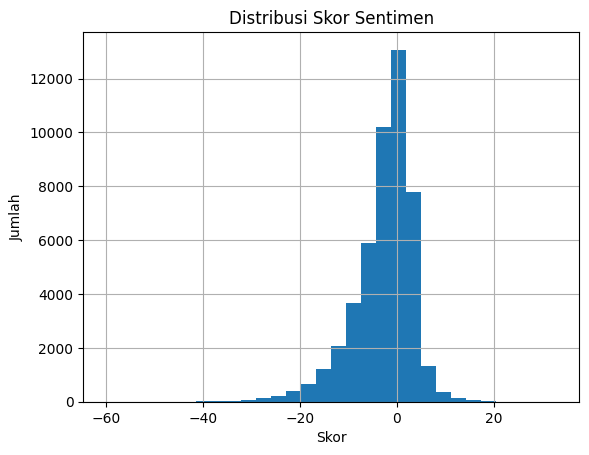

In [42]:
#Menampilkan distribusi score polarity
nel['polarity_score'].hist(bins=30)
plt.title('Distribusi Skor Sentimen')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()


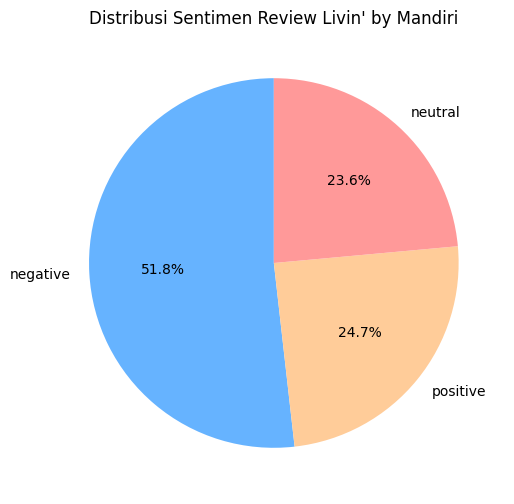

In [43]:
#Menampilkan diagram lingkaran berdasarkan polarity
sentiment_counts = nel['polarity'].value_counts()

# Membuat pie chart
plt.figure(figsize=(6, 6))
colors = ['#66b3ff','#ffcc99','#ff9999']  # Warna untuk positive, neutral, negative
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

# Tambahan estetika
plt.title('Distribusi Sentimen Review Livin\' by Mandiri')
plt.ylabel('')  # Menghapus label sumbu Y karena tidak dibutuhkan di pie chart
plt.show()

# **Word Cloud Umum**

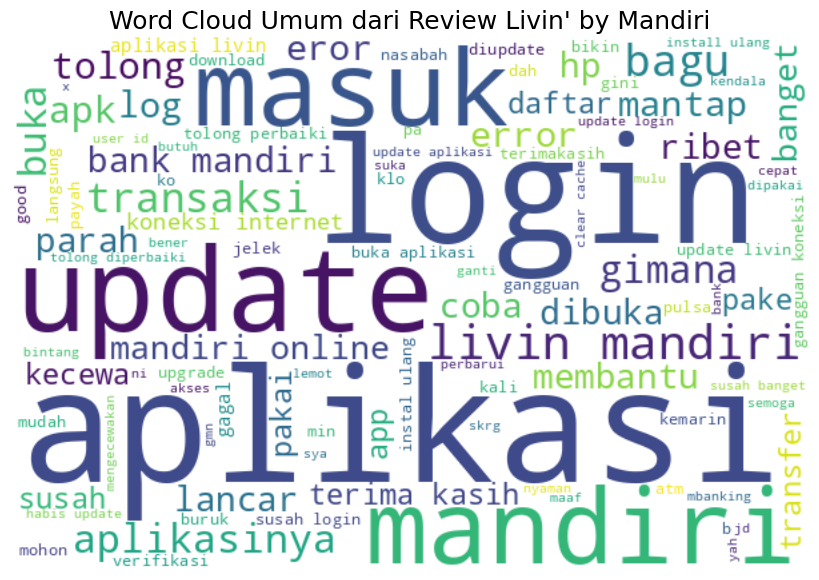

In [44]:
#Menampilkan kata umum yang sering muncul
list_words = ''

for tweet in nel['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat word cloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Umum dari Review Livin\' by Mandiri', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()

# **Word Cloud Positif**

In [45]:
#Mengambil data yang positif
positive_tweets = nel[nel['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

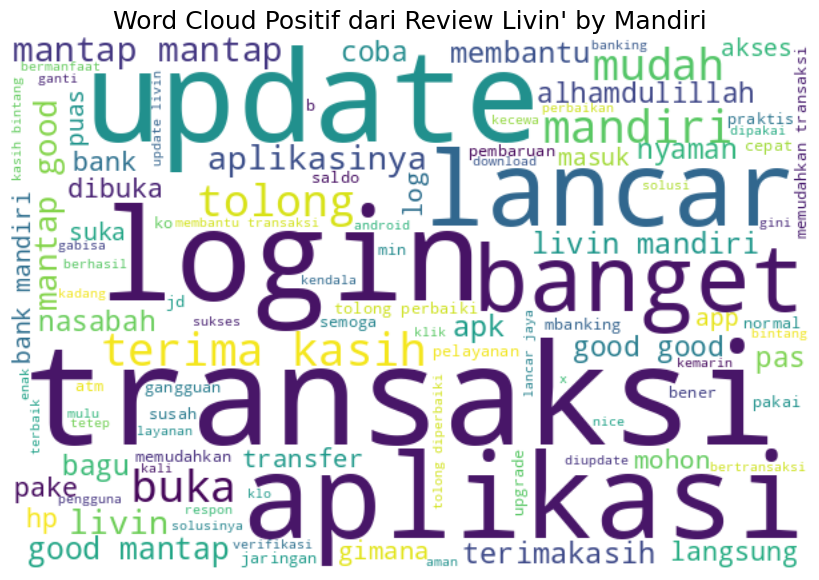

In [46]:
#Menampilkan kata positif yang sering muncul
list_words = ''
for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Positif dari Review Livin\' by Mandiri', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()

# **Word Cloud Negatif**

In [47]:
#Mengambil data yang negatif
# Ambil tweet yang negatif
negative_tweets = nel[nel['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

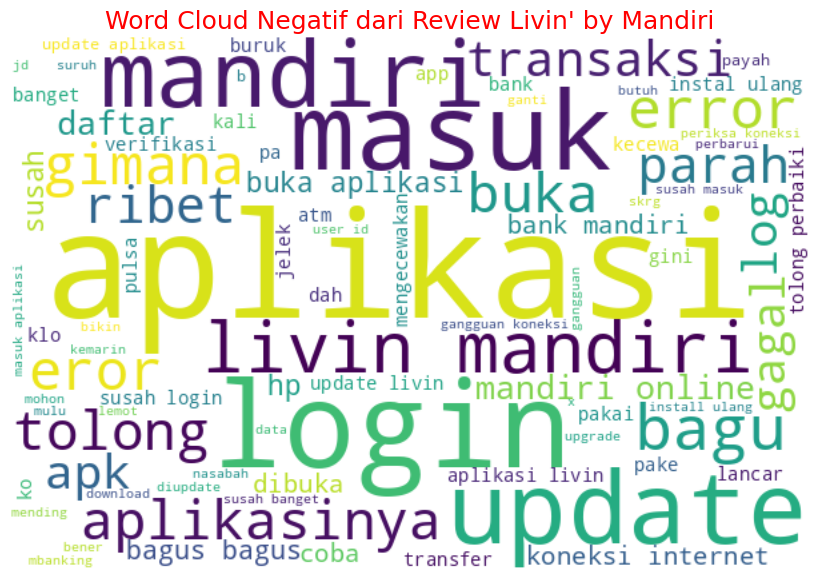

In [48]:
#Menampilkan kata negatif yang sering muncul
# Gabungkan semua kata dari text_stopword jadi satu string
list_words = ''
for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Negatif dari Review Livin\' by Mandiri', fontsize=18, color='red')
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()

# **Word Cloud Netral**

In [49]:
#Menampilkan data yang netral
netral_tweets = nel[nel['polarity'] == 'neutral']
netral_tweets = netral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
netral_tweets = netral_tweets.sort_values(by='polarity_score', ascending=False)
netral_tweets = netral_tweets.reset_index(drop=True)
netral_tweets.index += 1

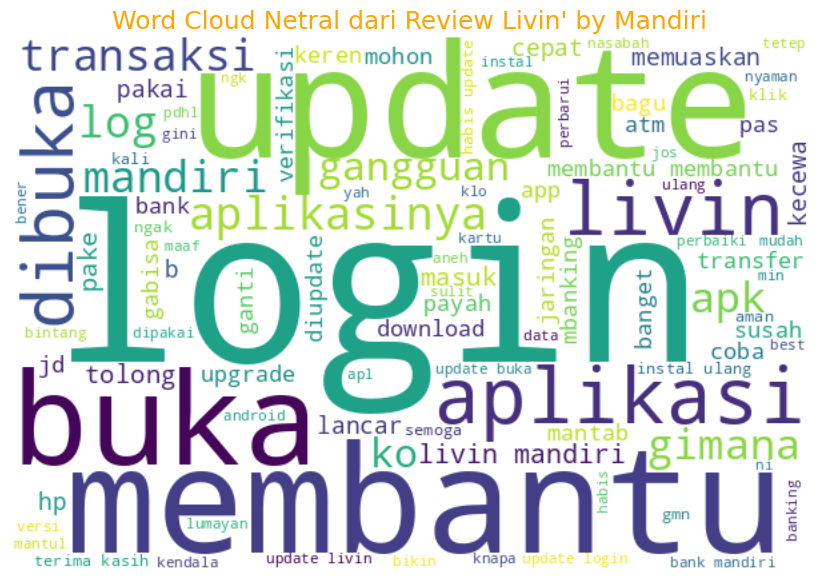

In [50]:
#Menampilkan kata netral yang sering muncul
list_words = ''
for tweet in netral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Netral dari Review Livin\' by Mandiri', fontsize=18, color='orange')  # Ubah teks 'neutral' jadi 'Netral'
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()

# **Visualisasi Text**

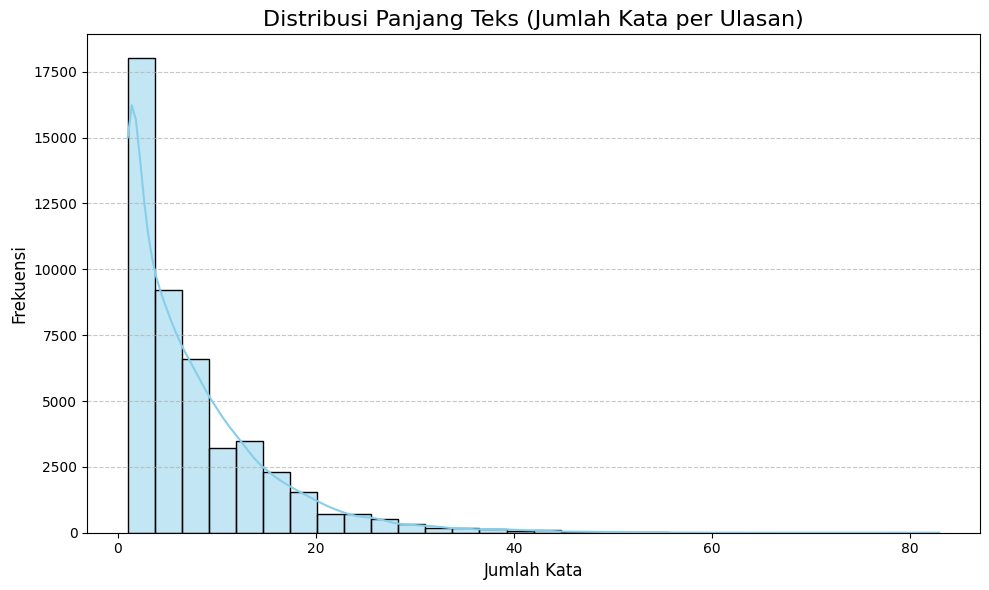

In [51]:
# Menampilkan distribusi panjang suatu text
nel['text_length'] = nel['text_stopword'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(nel['text_length'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribusi Panjang Teks (Jumlah Kata per Ulasan)', fontsize=16)
plt.xlabel('Jumlah Kata', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()






"Sebagian besar ulasan terdiri dari 10–30 kata, menandakan bahwa pengguna lebih cenderung memberikan komentar singkat dan langsung. Beberapa ulasan bahkan memiliki panjang 0 karena hanya berisi emotikon tanpa teks, yang kemudian difilter dalam proses preprocessing."

<ipython-input-52-a78af8beb3ec>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jumlah', y='index', data=tfidf_df, palette='viridis')


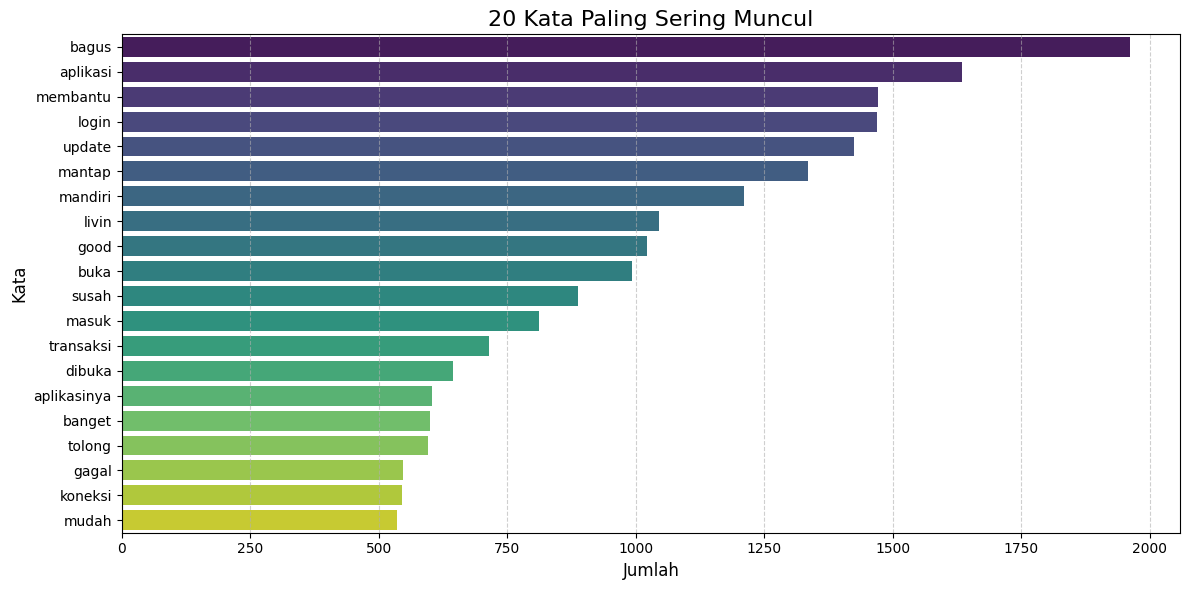

In [52]:
#Menampilkan kata yang sering muncul

plt.figure(figsize=(12, 6))

# Menggunakan TF-IDF untuk mencari kata paling sering muncul
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nel['text_akhir'])  # Menggunakan dataset 'nel' dan kolom 'text_akhir'

# Konversi hasil TF-IDF menjadi DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Menjumlahkan bobot tiap kata, lalu mengurutkan dari yang tertinggi
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Visualisasi
sns.barplot(x='jumlah', y='index', data=tfidf_df, palette='viridis')
plt.title('20 Kata Paling Sering Muncul', fontsize=16)
plt.xlabel('Jumlah', fontsize=12)
plt.ylabel('Kata', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


"Frekuensi kata tertinggi berasal dari kata-kata umum yang berkaitan langsung dengan penggunaan aplikasi seperti aplikasi, mandiri, dan livin. Ini menunjukkan keterkaitan langsung topik dengan produk Mandiri."

# **Modeling**

Pemodelan yang akan saya lakukan adalah sebagai berikut :
* Pelatihan: Logistic Regression,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20
* Pelatihan: SVM,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20
* Pelatihan: Logistic Regression,    Ekstraksi Fitur: CountVectorizer,    Pembagian Data: 70/30    
* Pelatihan : DNN,    Ekstraksi Fitur: Tokenizer + Keras Embedding, Pembagian Data : 75/25
* Pelatihan : DNN,    Ekstraksi Fitur: TF-IDF, Pembagian Data : 70/30

In [53]:
#Pisahkan fitur dan label
X = nel['text_akhir']
y = nel['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=15, max_df=0.6)
X_tfidf = tfidf.fit_transform(X)

#Konversi hasil ekstraksi fitur menjadi dataframe
features_nel = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_nel


,aamiin,abal,account,ad,admin,aduh,agustus,ah,ahh,aj,...,yahh,yak,yapadahal,yh,yng,youtube,yt,yth,zaman,zonk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [55]:
# Model 1: Logistic Regression + TF-IDF + 80/20
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9287598944591029
Logistic Regression - accuracy_test: 0.9103957783641161


In [56]:
# Model 2: SVM + TF-IDF + 80/20
X = nel['text_akhir']
y = nel['polarity']
tfidf_2 = TfidfVectorizer(max_features=5000, min_df=50, max_df=0.8)
X_tfidf_2 = tfidf_2.fit_transform(X)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf_2, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_2, y_train_2)

train_acc_2 = accuracy_score(y_train_2, svm_model.predict(X_train_2))
test_acc_2 = accuracy_score(y_test_2, svm_model.predict(X_test_2))
print("Train Accuracy:", train_acc_2)
print("Test Accuracy:", test_acc_2)


Train Accuracy: 0.9230343007915567
Test Accuracy: 0.9158839050131926


In [57]:
# Model 3: Logistic Regression + CountVectorizer + 70/30
count_vec = CountVectorizer(max_features=5000)
X_count = count_vec.fit_transform(X)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_count, y, test_size=0.2, random_state=42)

log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train_3, y_train_3)

train_acc_3 = accuracy_score(y_train_3, log_model.predict(X_train_3))
test_acc_3 = accuracy_score(y_test_3, log_model.predict(X_test_3))
print("Train Accuracy:", train_acc_3)
print("Test Accuracy:", test_acc_3)


Train Accuracy: 0.9610554089709763
Test Accuracy: 0.9209498680738786


In [58]:
# Model 4 : Dense Neural Network + Tokenizer + Keras Embedding 75/25
label_encoder = LabelEncoder()
nel['label'] = label_encoder.fit_transform(nel['polarity'])  # negative: 0, netral: 1, positive: 2
X = nel['text_akhir'].astype(str)
y = nel['label']

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, padding='post', maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.25, random_state=42, stratify=y)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

def evaluate_model(model, name):
    train_loss, train_acc_4 = model_dense.evaluate(X_train, y_train_cat, verbose=0)
    test_loss, test_acc_4 = model_dense.evaluate(X_test, y_test_cat, verbose=0)
    print(f"{name} - accuracy_train: {train_acc_4:.4f}")
    print(f"{name} - accuracy_test: {test_acc_4:.4f}\n")
model_dense = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dense.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])
evaluate_model(model_dense, "Dense NN")

train_loss_4, train_acc_4 = model_dense.evaluate(X_train, y_train_cat, verbose=0)
test_loss_4, test_acc_4 = model_dense.evaluate(X_test, y_test_cat, verbose=0)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


889/889 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7131 - loss: 0.6914 - val_accuracy: 0.8995 - val_loss: 0.2760
Epoch 2/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9134 - loss: 0.2372 - val_accuracy: 0.9130 - val_loss: 0.2225
Epoch 3/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9430 - loss: 0.1486 - val_accuracy: 0.9232 - val_loss: 0.2095
Epoch 4/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9611 - loss: 0.1086 - val_accuracy: 0.9230 - val_loss: 0.2200
Epoch 5/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9716 - loss: 0.0835 - val_accuracy: 0.9228 - val_loss: 0.2307
Dense NN - accuracy_train: 0.9701
Dense NN - accuracy_test: 0.9238



In [59]:
# Model 5 : DNN +TF-IDF (70/30)
label_encoder = LabelEncoder()
nel['label'] = label_encoder.fit_transform(nel['polarity'])  # negative: 0, netral: 1, positive: 2

# TF-IDF Ekstraksi
X = nel['text_akhir'].astype(str)
y = nel['label']

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf.toarray(), y, test_size=0.30
    , stratify=y, random_state=42)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

model_tfidf_dnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_tfidf_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_tfidf_dnn.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2,
                    callbacks=[EarlyStopping(patience=2)], verbose=1)

# Evaluasi
train_loss, train_acc_5 = model_tfidf_dnn.evaluate(X_train, y_train_cat, verbose=0)
test_loss, test_acc_5 = model_tfidf_dnn.evaluate(X_test, y_test_cat, verbose=0)

print(f"Dense NN + TF-IDF - accuracy_train: {train_acc_5:.4f}")
print(f"Dense NN + TF-IDF - accuracy_test: {test_acc_5:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7266 - loss: 0.6190 - val_accuracy: 0.9062 - val_loss: 0.2623
Epoch 2/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9144 - loss: 0.2428 - val_accuracy: 0.9207 - val_loss: 0.2362
Epoch 3/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9378 - loss: 0.1970 - val_accuracy: 0.9210 - val_loss: 0.2360
Epoch 4/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9440 - loss: 0.1757 - val_accuracy: 0.9237 - val_loss: 0.2370
Epoch 5/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9567 - loss: 0.1428 - val_accuracy: 0.9195 - val_loss: 0.2558
Dense NN + TF-IDF - accuracy_train: 0.9630
Dense NN + TF-IDF - accuracy_test: 0.9187


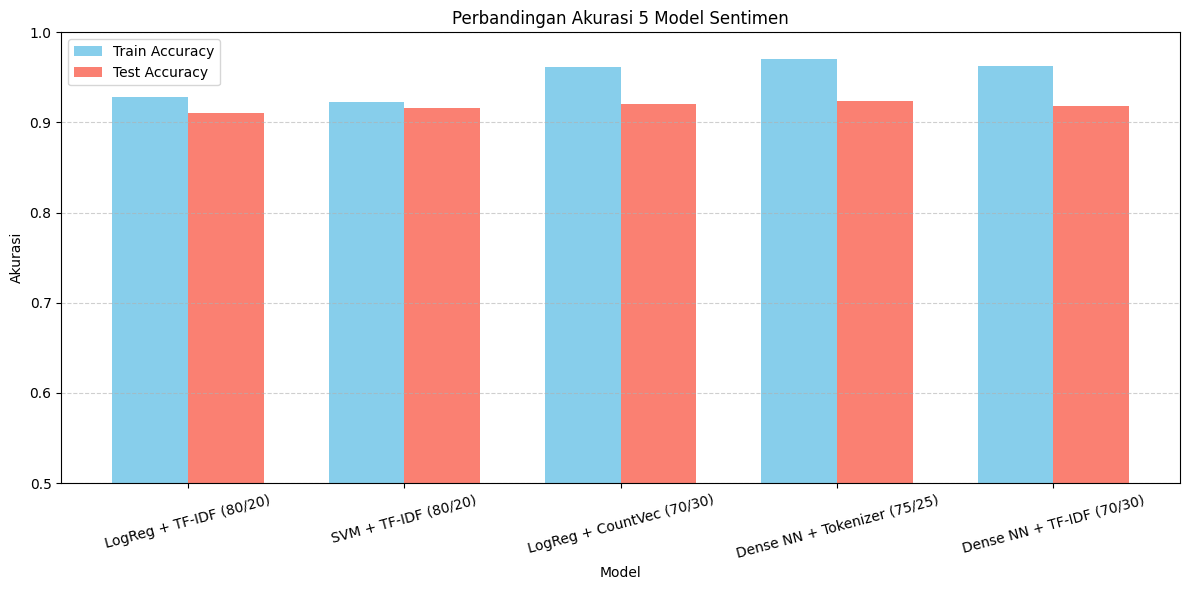

In [60]:
# Menampilkan visualisasi diagram batang berdasarkan model yang dilatih
model_names = [
    "LogReg + TF-IDF (80/20)",
    "SVM + TF-IDF (80/20)",
    "LogReg + CountVec (70/30)",
    "Dense NN + Tokenizer (75/25)",
    "Dense NN + TF-IDF (70/30)"
]

# Akurasi masing-masing model
train_accuracies = [
    accuracy_train_lr,
    train_acc_2,
    train_acc_3,
    train_acc_4,
    train_acc_5
]

test_accuracies = [
    accuracy_test_lr,
    test_acc_2,
    test_acc_3,
    test_acc_4,
    test_acc_5
]

# Plot bar chart
x = range(len(model_names))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, train_accuracies, width=bar_width, label='Train Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], test_accuracies, width=bar_width, label='Test Accuracy', color='salmon')

plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi 5 Model Sentimen')
plt.xticks([i + bar_width/2 for i in x], model_names, rotation=15)
plt.legend()
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [61]:
# Menampilkan ringkasan hasil akurasi
hasil_akurasi = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies
})

print(hasil_akurasi)


                          Model  Train Accuracy  Test Accuracy
0       LogReg + TF-IDF (80/20)        0.928760       0.910396
1          SVM + TF-IDF (80/20)        0.923034       0.915884
2     LogReg + CountVec (70/30)        0.961055       0.920950
3  Dense NN + Tokenizer (75/25)        0.970054       0.923843
4     Dense NN + TF-IDF (70/30)        0.963000       0.918736


Berdasarkan hasil akurasi train dan test tersebut terdapat 2 model yang dipakai memenuhi kriteria minimal 92% untuk mendapatkan nilai maksimal.


* **Model dengan Akurasi Tertinggi :**
Model Dense Neural Network + Tokenizer (75/25) menunjukkan performa terbaik baik dari sisi akurasi pelatihan (97.27%) maupun akurasi pengujian (92.41%). Ini menunjukkan bahwa pendekatan menggunakan tokenizer dan embedding dari Keras mampu menangkap representasi teks dengan baik untuk tugas klasifikasi sentimen.

* **Performa Kuat dari Model Berbasis TF-IDF dan Deep Learning :**
Model Dense NN + TF-IDF (70/30) juga menunjukkan performa yang sangat baik, dengan akurasi pelatihan 96.49% dan akurasi pengujian 92.03%. Artinya, representasi TF-IDF tetap efektif jika dikombinasikan dengan arsitektur jaringan syaraf tiruan.

* **Model Machine Learning Klasik Tetap Kompetitif :**
Model seperti LogReg + CountVectorizer (70/30) mencatat akurasi pelatihan 96.11% dan akurasi pengujian 92.09%, yang cukup kompetitif dan bahkan sedikit mengungguli model deep learning berbasis TF-IDF. Ini menunjukkan bahwa model klasik tetap relevan terutama pada dataset yang besar dan bersih.

* **Gap Overfitting yang Rendah :**
Semua model menunjukkan gap yang kecil antara akurasi training dan testing, yang berarti risiko overfitting rendah dan model mampu melakukan generalisasi dengan baik terhadap data baru.

* **Model SVM Sedikit Tertinggal di Dataset Ini :**
Meskipun SVM dikenal kuat, pada eksperimen ini SVM + TF-IDF mencatat akurasi training 92.30% dan testing 91.58%, sedikit lebih rendah dari model lain. Hal ini bisa jadi karena SVM tidak optimal menangani kompleksitas atau skala data sebesar ini tanpa fine-tuning parameter lebih lanjut.

In [73]:
label_encoder = LabelEncoder()
label_encoder.fit(nel['polarity'])
kalimat_baru = [
    "Saya sangat puas dengan fitur-fitur yang ditawarkan, semuanya berjalan lancar tanpa hambatan.",
    "Terlalu sering error, saya kecewa sekali",
    "User interface-nya oke, tapi fiturnya kurang lengkap",
    "Gak bisa login padahal sinyal bagus",
    "Aplikasi ini sering error dan membuat saya kesal.",
    "Saya sangat puas dengan fitur-fitur yang ditawarkan, semuanya berjalan lancar tanpa hambatan."
]
kalimat_baru_tfidf = tfidf.transform(kalimat_baru)
prediksi = model_tfidf_dnn.predict(kalimat_baru_tfidf.toarray())
hasil_kategori = label_encoder.inverse_transform(np.argmax(prediksi, axis=1))
for kalimat, label in zip(kalimat_baru, hasil_kategori):
    print(f"Kalimat: {kalimat}")
    print(f"Prediksi Sentimen: {label}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Kalimat: Saya sangat puas dengan fitur-fitur yang ditawarkan, semuanya berjalan lancar tanpa hambatan.
Prediksi Sentimen: positive
--------------------------------------------------
Kalimat: Terlalu sering error, saya kecewa sekali
Prediksi Sentimen: negative
--------------------------------------------------
Kalimat: User interface-nya oke, tapi fiturnya kurang lengkap
Prediksi Sentimen: neutral
--------------------------------------------------
Kalimat: Gak bisa login padahal sinyal bagus
Prediksi Sentimen: negative
--------------------------------------------------
Kalimat: Aplikasi ini sering error dan membuat saya kesal.
Prediksi Sentimen: negative
--------------------------------------------------
Kalimat: Saya sangat puas dengan fitur-fitur yang ditawarkan, semuanya berjalan lancar tanpa hambatan.
Prediksi Sentimen: positive
--------------------------------------------------
